In [4]:
import os
import sys
sys.path.append('./src')
sys.path.append('../../') # to get bindings
#sys.path.append('./dependencies/indy-ros2/indy_description/urdf_files')

from utils import *
#from gato_mpc import *
from gato_mpc_batch import *
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer
import meshcat.geometry as g
import meshcat.transformations as tf
import numpy as np
np.set_printoptions(linewidth=99999999)

# Load robot model
model_dir = "description/"
urdf_path = model_dir + "indy7.urdf"
model, visual_model, collision_model = load_robot_model(urdf_path, model_dir)

# Create MPC solver and optimizer
#controller = MPC_GATO(model, N=32, dt=0.01)
controller = MPC_GATO_Batch(model, N=32, dt=0.01, batch_size=1)


In [5]:
# initial state
#xstart = np.zeros(controller.nx)
xstart = np.hstack((np.ones(controller.nq), np.zeros(controller.nv)))

# goal ee positions
endpoints = np.array([
    np.array(controller.eepos(np.zeros(controller.nq))),
    #np.array(controller.eepos(0.3*np.ones(controller.nq))),
    #np.array(controller.eepos(np.zeros(controller.nq))), 
    np.array(controller.eepos(np.array([-3.0, 1.0, 1.0, 1.0, 0.0, 0.0]))),
    np.array(controller.eepos(0.8*np.ones(controller.nq))),
    np.array(controller.eepos(np.zeros(controller.nq))),
    np.array(controller.eepos(-1.6*np.ones(controller.nq))),
    np.array(controller.eepos(np.zeros(controller.nq))),
])

# Run MPC
q_trajectory, mpc_stats = controller.run_mpc(xstart, endpoints, 0.001, 5)

Running MPC with 5000 steps, sim_dt: 0.001
Endpoints:
[[ 1.51468905e-10 -1.86500000e-01  1.26750000e+00]
 [ 8.90168461e-01  2.30300636e-01  4.67093951e-01]
 [-3.95133249e-01 -7.18955801e-01  6.46672286e-01]
 [ 1.51468905e-10 -1.86500000e-01  1.26750000e+00]
 [-1.83963491e-01 -6.12057973e-01 -6.91099486e-02]
 [ 1.51468905e-10 -1.86500000e-01  1.26750000e+00]]
t:    0.000, goal dist:  1.07009
t:    0.050, goal dist:  1.00716
t:    0.100, goal dist:  0.72560
t:    0.200, goal dist:  0.22518
Reached intermediate goal 1, moving to next goal: [0.89016846 0.23030064 0.46709395 0.         0.         0.        ]
t:    0.350, goal dist:  1.09181
t:    0.400, goal dist:  0.90172
t:    0.550, goal dist:  0.25731
Reached intermediate goal 2, moving to next goal: [-0.39513325 -0.7189558   0.64667229  0.          0.          0.        ]
t:    0.700, goal dist:  1.55170
t:    0.800, goal dist:  0.89781
t:    0.950, goal dist:  0.26432
Reached intermediate goal 3, moving to next goal: [ 1.51468905e-10 

In [12]:
for key in mpc_stats:
    print(key)
    print(mpc_stats[key])

solve_times
[0.00952, 0.02348, 0.02276, 0.01405, 0.0108, 0.01911, 0.02687, 0.02296, 0.02374, 0.0221, 0.02703, 0.02962, 0.02537, 0.01864, 0.02589, 0.02685, 0.00989]
goal_distances
[1.07009, 1.08098, 1.06241, 0.90052, 0.75506, 0.73421, 0.7426, 0.91115, 1.06367, 1.337, 1.45866, 1.44632, 1.04802, 0.96581, 0.7966, 0.79439, 1.01039]
control_inputs
[array([0., 0., 0., 0., 0., 0.], dtype=float32), array([  1.15559, -12.51648, -25.83287,  15.27238,   8.20297,   0.04605], dtype=float32), array([ 7.8258700e+00, -1.0363015e+02, -5.3352280e+01,  9.4263401e+00,  4.8980198e+00, -8.9570001e-02], dtype=float32), array([ 6.488820e+00, -8.927142e+01, -2.094196e+01,  5.055990e+00, -2.247560e+00, -1.906000e-02], dtype=float32), array([ 8.5836802e+00, -1.2507466e+02, -4.4153061e+01, -1.3925430e+01, -3.0016000e+00,  9.4100004e-03], dtype=float32), array([ 3.585780e+00, -6.920398e+01, -1.168620e+00, -2.230470e+00, -1.228080e+00,  1.636000e-02], dtype=float32), array([ 2.96100e-01, -2.05055e+01,  4.30230e-01, 

In [ ]:
stats = controller.solver.get_stats()
for key in stats:
    print(key)
    print(stats[key])

solve_time
{'values': [59669.0, 42957.0, 47856.0, 44166.0, 53524.0, 45129.0, 45893.0, 50144.0, 41344.0, 46259.0, 47730.0, 48653.0, 41917.0, 38840.0, 37658.0, 47352.0, 44930.0, 49375.0, 46301.0, 52239.0, 52166.0, 50296.0, 50399.0, 49919.0, 51822.0, 48999.0, 50432.0, 49468.0, 50884.0, 52948.0, 51968.0, 46528.0, 50516.0, 52307.0, 51284.0, 50131.0, 49143.0, 52436.0, 51918.0, 54561.0, 47648.0, 53054.0, 50773.0, 51353.0, 53303.0, 51482.0, 52694.0, 50709.0, 53874.0, 53432.0, 52956.0, 53950.0, 54928.0, 55150.0, 55445.0, 54326.0, 53881.0, 54531.0, 51354.0, 50472.0, 51486.0, 55397.0, 58082.0, 53218.0, 49607.0, 51114.0, 53263.0, 48439.0, 54557.0, 54108.0, 55448.0, 47930.0, 50862.0, 52083.0, 53749.0, 50604.0, 52693.0, 50994.0, 52080.0, 53229.0, 53861.0, 50164.0, 53733.0, 51760.0, 50127.0, 56436.0, 56878.0, 54223.0, 50338.0, 53649.0, 54897.0, 53695.0, 53394.0, 50971.0, 49785.0, 50893.0, 52429.0, 55411.0, 46960.0, 48995.0, 49489.0, 53334.0, 47015.0, 50710.0, 48264.0, 51299.0, 51599.0, 54717.0, 52307

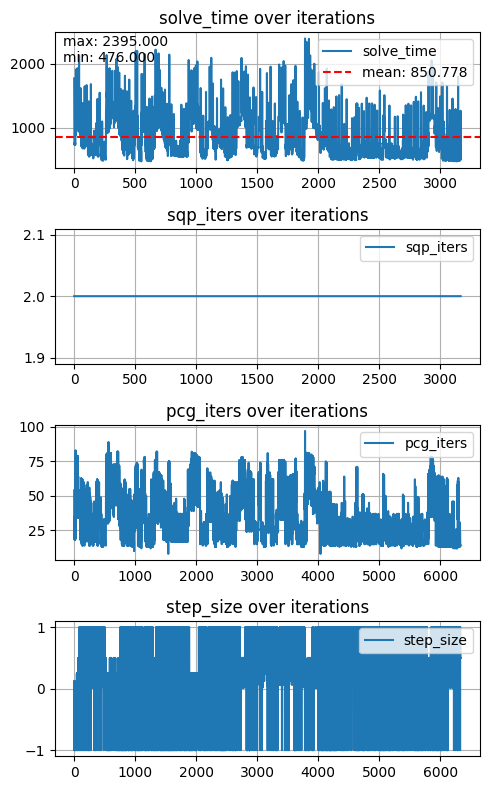

In [6]:
stats = controller.solver.get_stats()

import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(stats), 1, figsize=(5, 2*len(stats)))
if len(stats) == 1:
    axs = [axs]

for i, (key, data) in enumerate(stats.items()):
    ax = axs[i]
    if isinstance(data, dict) and 'values' in data:
        values = data['values']
        ax.plot(values, label=key)
        ax.set_title(f'{key} over iterations')
        if key == 'solve_time':
            ax.axhline(np.mean(values), color='r', linestyle='--', label=f'mean: {np.mean(values):.3f}')
            ax.text(0.02, 0.98, f'max: {np.max(values):.3f}\nmin: {np.min(values):.3f}', 
                   transform=ax.transAxes, verticalalignment='top')
    else:
        ax.plot(data, label=key)
        ax.set_title(f'{key} over iterations')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()
    

In [7]:
# Setup pinocchio visualizer
viz = MeshcatVisualizer(model, collision_model, visual_model)
viz.initViewer()
viz.loadViewerModel()
# Visualize goals
for i, p in enumerate(endpoints):
    viz.viewer[f'point{i}'].set_object(
        g.Sphere(0.05), 
        g.MeshLambertMaterial(color=0xff0000))

    T = tf.translation_matrix(np.array(p[:]))
    viz.viewer[f'point{i}'].set_transform(T)
#print_stats(controller.solver.get_stats())
while 1:
    viz.play(q_trajectory=q_trajectory, dt=0.001)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7009/static/


KeyboardInterrupt: 

In [5]:
import pickle

print(q_trajectory)

# save trajectory to file
with open('q_trajectory.pkl', 'wb') as f:
    pickle.dump(q_trajectory, f)

[array([-0.10000215, -0.09995034, -0.10001428, -0.09973532, -0.10049627, -0.09970045]), array([-0.09999626, -0.0998874 , -0.10006218, -0.09946834, -0.1010091 , -0.09937014]), array([-0.09995853, -0.09966929, -0.10040356, -0.09892561, -0.10215607, -0.09848081]), array([-0.09993001, -0.09951316, -0.10071102, -0.09867053, -0.10275819, -0.09793127]), array([-0.10019403, -0.09893406, -0.10222653, -0.09829681, -0.10427466, -0.09615428]), array([-0.1005488 , -0.0984754 , -0.10358971, -0.09826648, -0.10516703, -0.09485713]), array([-0.10239259, -0.09691284, -0.10887264, -0.09938004, -0.10757959, -0.08959294]), array([-0.10401465, -0.09575326, -0.11306962, -0.10072823, -0.10908071, -0.08537751]), array([-0.10919641, -0.09250383, -0.12536881, -0.10528646, -0.11285667, -0.07426548]), array([-0.11285042, -0.09038437, -0.13363976, -0.10860579, -0.11509966, -0.06769667]), array([-0.12233224, -0.08490463, -0.1553781 , -0.11750124, -0.11957864, -0.05210192]), array([-0.12813764, -0.08150659, -0.168991